In [1]:
import numpy as np
from progressbar import progressbar as pb
import itertools
import collections
import re
from sklearn.model_selection import train_test_split as TTS

In [2]:
import pandas as pd
import numpy as np
from progressbar import progressbar as pb
df = pd.read_csv('all_data_fixed3.csv')
df.head()

,0,1,2,3,4,5
0,Совещательный орган при императоре в начале XX в,Сенат,Государственный совет,Консилия министров,Верховный тайный совет,2
1,Министр внутренних дел с 1904 г либерал автор ...,Лорис Меликов,Святополк Мирский,Милюков,Витте,2
2,Какое из названных событий произошло 27 января...,подрыв флагманского корабля Петропавловск,высадка японских войск на Ляодунском полуострове,героический бой Варяга и Корейца,заключение Портсмутского мирного договора,3
3,Что из названного относится к результатам перв...,появление многопартийности,формирование конституционной монархии,ликвидация сословного строя,введение рабочего контроля за производством,1
4,Для выхода из экономического кризиса вызванног...,ввело 8 часовой рабочий день в промышленности,ликвидировало помещичье землевладение,отменило выкупные платежи,ввело продовольственную разверстку,4


In [3]:
import pickle

with open('Embeddings/elmo_embed3.pickle', 'rb') as f:
    elmo_embs = pickle.load(f)

elmo_embs = np.array(elmo_embs)

In [4]:
samples = elmo_embs
target = np.array(df['5'])

X_train, X_test, y_train, y_test = TTS(samples, target, test_size=0.25)

In [21]:
def get_batch(X_val, y_val, batch_sz=16, shuffle=True):
    
    '''
    Разбиение выборки на батчи заданного размера.
    
    X_val - векторное представление данных
    y_val - разметка
    batch_sz - размер одного батча
    shuffle - перемешивание элементов по батчам
    
    return:
    
    X_batches, y_batches - разделенная по батчам выборка    
    
    '''
    
    X_batches, y_batches = [], []
    
    samples_num = len(X_val)
    samples_inds = np.arange(samples_num)
    
    if shuffle:
        np.random.shuffle(samples_inds)
    
    cur_x, cur_y = [], []
    
    for i, cur_ind in enumerate(samples_inds):
        if i % batch_sz < batch_sz-1:
            cur_x.append(X_val[cur_ind])
            cur_y.append(y_val[cur_ind]-1)
        else:
            cur_x.append(X_val[cur_ind])
            cur_y.append(y_val[cur_ind]-1)
            X_batches.append(cur_x)
            y_batches.append(cur_y)
            cur_x, cur_y = [], []
          
    X_batches.append(cur_x)
    y_batches.append(cur_y)
    
    return np.array(X_batches), np.array(y_batches)

In [22]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity as cos

Подаем в сеть ембеддинг вопроса и ембеддинги вариантов ответов. Сеть содержит отдельные слои для вопроса и отдельные слои для всех вариантов ответов.

In [23]:
class DSSMNet(nn.Module):
    def __init__(self, bow_size):
        super().__init__()
        self.bow_size = bow_size
        self.linear_1_1 = nn.Linear(bow_size, 300)
        self.linear_1_2 = nn.Linear(300, 300)
        self.linear_1_3 = nn.Linear(300, 128)
        
        self.linear_2_1 = nn.Linear(bow_size, 300)
        self.linear_2_2 = nn.Linear(300, 300)
        self.linear_2_3 = nn.Linear(300, 128)      
        
    def forward(self, sample):
        bow_size = self.bow_size
        
        question = sample[:,0,:]
        answers = sample[:,1:,:]
        
        outputs = torch.Tensor().type(torch.cuda.FloatTensor)
        
        question = torch.tanh(self.linear_1_1(question))
        question = torch.tanh(self.linear_1_2(question))
        question = torch.tanh(self.linear_1_3(question))
        outputs = torch.cat((outputs, question.unsqueeze(0)), dim=0)
        
        for i in range(answers.shape[1]):
            answer = torch.tanh(self.linear_2_1(answers[:,i,:]))
            answer = torch.tanh(self.linear_2_2(answer))
            answer = torch.tanh(self.linear_2_3(answer))
            outputs = torch.cat((outputs, answer.unsqueeze(0)), dim=0)
        
        
        cosines = torch.Tensor().type(torch.cuda.FloatTensor)
        
        for i in range(1,len(outputs)):
            cosines = torch.cat((cosines, F.cosine_similarity(outputs[0], outputs[i], dim=1).unsqueeze(0)))
            
        probs = F.softmax(cosines.view(-1,4))
        
        return probs     

In [47]:
model = DSSMNet(elmo_embs.shape[2])
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
epochs = 50

In [48]:
def train(model, optimizer, X_train, y_train, batch_size, shuffle):
    train_loss, train_acc = [], []
    model.train()
    X_batches, y_batches = get_batch(X_train, y_train, batch_size, shuffle)
    
    for batch in zip(X_batches, y_batches):
        X_batch, y_batch = batch
        X_batch, y_batch = np.array(X_batch), np.array(y_batch)
        
        X_batch = torch.from_numpy(X_batch).type(torch.cuda.FloatTensor)
        y_batch = torch.from_numpy(y_batch).type(torch.cuda.LongTensor)
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        train_loss.append(loss.item())
        
        max_ind = y_pred.max(1, keepdim=True)[1]
        target_matches = torch.eq(max_ind, y_batch.data.view(len(y_batch), 1))
        accuracy = torch.sum(target_matches).cpu().numpy() / len(y_batch)
        train_acc.append(accuracy)
        
        loss.backward()
        optimizer.step()
        
    return np.mean(train_loss), np.mean(train_acc)

In [49]:
def validate(model, optimizer, X_test, y_test, batch_size, shuffle):
    val_loss, val_acc = [], []
    model.eval()
    X_batches, y_batches = get_batch(X_test, y_test, batch_size, shuffle)
    
    for batch in zip(X_batches, y_batches):
        X_batch, y_batch = batch
        X_batch, y_batch = np.array(X_batch), np.array(y_batch)
        
        X_batch = torch.from_numpy(X_batch).type(torch.cuda.FloatTensor)
        y_batch = torch.from_numpy(y_batch).type(torch.cuda.LongTensor)
        
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        val_loss.append(loss.item())
        
        max_ind = y_pred.max(1, keepdim=True)[1]
        target_matches = torch.eq(max_ind, y_batch.data.view(len(y_batch), 1))
        accuracy = torch.sum(target_matches).cpu().numpy() / len(y_batch)
        val_acc.append(accuracy)
         
    return np.mean(val_loss), np.mean(val_acc)

In [50]:
def launch_net(model, optimizer, X_train, y_train, X_test, y_test, shuffle=True,\
               train_batch=64, test_batch=16, epochs=25):
    all_train_loss, all_val_loss = [], []
    all_train_acc, all_val_acc = [], []
    max_acc = 0

    for epoch in pb(range(epochs)):
        cur_train = train(model, optimizer, X_train, y_train, train_batch, shuffle)
        cur_val = validate(model, optimizer, X_test, y_test, test_batch, shuffle)
        all_train_loss.append(cur_train[0])
        all_train_acc.append(cur_train[1])
        all_val_loss.append(cur_val[0])
        all_val_acc.append(cur_val[1])
        max_acc = cur_val[1] if cur_val[1] > max_acc else max_acc
        clear_output()
        print('Epoch {}:'.format(epoch+1))
        print("Train loss: {}".format(cur_train[0]))
        print("Validation loss: {}".format(cur_val[0]))
        print("Train accuracy: {}".format(cur_train[1]))
        print("Validation accuracy: {}".format(cur_val[1]))
        print("Max validation accuracy: {}".format(max_acc))
        
        f, axarr = plt.subplots(1,2, figsize=(20,10))

        axarr[0].plot(all_train_loss, label='Train loss')
        axarr[0].plot(all_val_loss, label='Val loss')
        axarr[0].grid()
        axarr[0].legend(fontsize=15)
        axarr[0].set_title('Loss after epoch #{}'.format(epoch+1), size=15)

        axarr[1].plot(all_train_acc, label='Train accuracy')
        axarr[1].plot(all_val_acc, label='Val accuracy')
        axarr[1].grid()
        axarr[1].legend(fontsize=15)
        axarr[1].set_title('Accuracy after epoch #{}'.format(epoch+1), size=15)
        plt.show()

Epoch 50:
Train loss: 1.3861684818116446
Validation loss: 1.3864262458823977
Train accuracy: 0.2548234811165846
Validation accuracy: 0.24375000000000002
Max validation accuracy: 0.2732142857142857


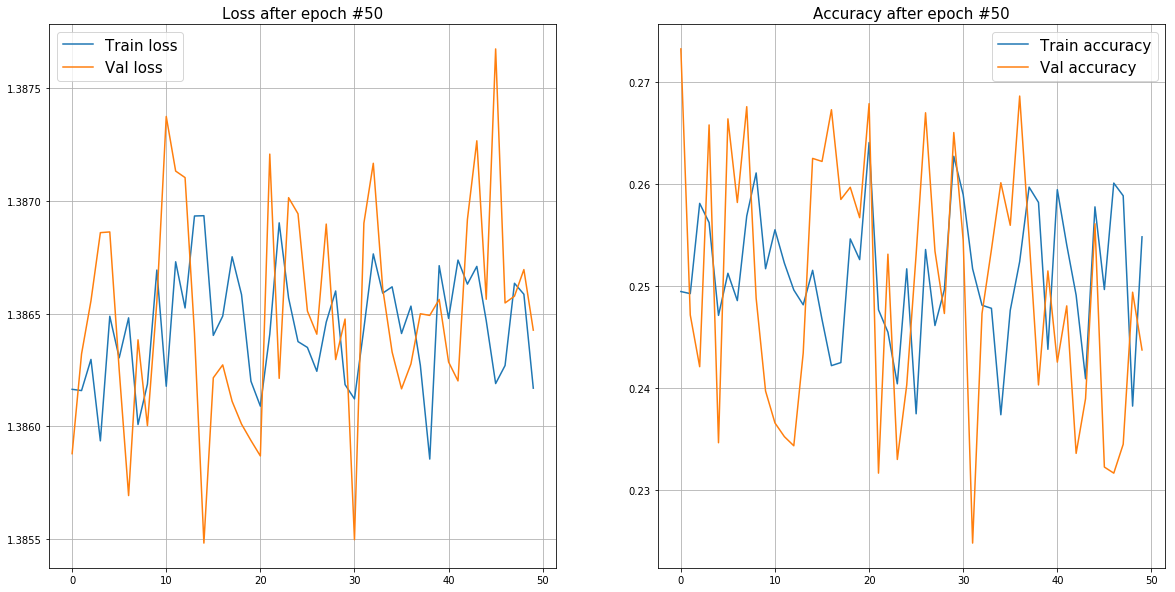

100% (50 of 50) |########################| Elapsed Time: 0:01:18 Time:  0:01:18


In [51]:
launch_net(model, optimizer, X_train, y_train, X_test, y_test, True, 64, 16, epochs)